#Deep Learning - Project

*Irland news headlines data*

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import nltk
import regex
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import WordPunctTokenizer
from string import punctuation
import plotly.express as px
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import scipy.sparse as sp
from scipy.sparse import csr_matrix
from sklearn.feature_extraction.text import CountVectorizer

# https://www.kaggle.com/code/darkrubiks/classifying-irish-times-headlines-categories#Predicting-the-Headlines-Categories

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!ls "/content/drive/MyDrive/Untitled folder/ireland-news-headlines.csv"

'/content/drive/MyDrive/Untitled folder/ireland-news-headlines.csv'


In [ ]:
data = pd.read_csv('/content/drive/MyDrive/Untitled folder/ireland-news-headlines.csv')
data

,publish_date,headline_category,headline_text
0,19960102,news,UUP sees possibility of voting Major out
1,19960102,news,Pubs targeted as curbs on smoking are extended
2,19960102,news,Papers reveal secret links with O'Neill cabinet
3,19960102,news,Domestic chaos as Italy takes EU presidency
4,19960102,news,Learning about the star to which we owe life
...,...,...,...
1611490,20210630,news.politics.oireachtas,Reserve members of Defence Forces to be allowe...
1611491,20210630,culture,Maureen Dowd: Joe Biden is 'crazy about the Ir...
1611492,20210630,sport.others,Andy Murray rolls back the years to own Centre...
1611493,20210630,news.health,Delta variant could do 'significant damage' in...


In [ ]:
# !pip install kaggle
# import os
# os.environ['KAGGLE_CONFIG_DIR'] = '/content'
# !kaggle datasets download -d therohk/ireland-historical-news

# from zipfile import ZipFile
# with ZipFile('/content/ireland-historical-news.zip','r') as zip0bj:
#   zip0bj.extractall('/content')
# data = pd.read_csv('/content/ireland-news-headlines.csv')
# data

## Data Proccessing

In [ ]:
data.shape


(1611495, 3)

In [ ]:
data.isna().sum()

#We can see that we have 7 nulls in the headline text, we will remove them

publish_date         0
headline_category    0
headline_text        7
dtype: int64

In [ ]:
#removing the missing text articles
data = data.dropna()
data.isna().sum()

publish_date         0
headline_category    0
headline_text        0
dtype: int64

In [ ]:
data.duplicated().sum()
#Check what to do with it###

0

In [ ]:
#Checking how many istanses we have of each category over the years in the data set
data["headline_category"].value_counts()

news                               580238
sport                              158682
business                           111435
opinion.letters                     79276
opinion                             49946
                                    ...  
lifestyle.food.restaurant             203
news.technology                       191
business.markets.bonds                127
lifestyle.abroad.working-abroad       116
news.health.coronavirus               104
Name: headline_category, Length: 103, dtype: int64

In [ ]:
#Date modifications
#We will change the publish date to date time format
#We will add month and day date for further analyzing
data.loc[:, 'publish_date'] = pd.to_datetime(data['publish_date'], format='%Y%m%d')
data.loc[:, 'month'] = data['publish_date'].dt.month
data.loc[:, 'day'] = data['publish_date'].dt.day
data

<ipython-input-18-fefd81920beb>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.loc[:, 'publish_date'] = pd.to_datetime(data['publish_date'], format='%Y%m%d')
<ipython-input-18-fefd81920beb>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.loc[:, 'month'] = data['publish_date'].dt.month
<ipython-input-18-fefd81920beb>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docume

,publish_date,headline_category,headline_text,month,day
0,1996-01-02,news,UUP sees possibility of voting Major out,1,2
1,1996-01-02,news,Pubs targeted as curbs on smoking are extended,1,2
2,1996-01-02,news,Papers reveal secret links with O'Neill cabinet,1,2
3,1996-01-02,news,Domestic chaos as Italy takes EU presidency,1,2
4,1996-01-02,news,Learning about the star to which we owe life,1,2
...,...,...,...,...,...
1611490,2021-06-30,news.politics.oireachtas,Reserve members of Defence Forces to be allowe...,6,30
1611491,2021-06-30,culture,Maureen Dowd: Joe Biden is 'crazy about the Ir...,6,30
1611492,2021-06-30,sport.others,Andy Murray rolls back the years to own Centre...,6,30
1611493,2021-06-30,news.health,Delta variant could do 'significant damage' in...,6,30


In [ ]:
# Unifing sub-categories into main categories by first delimter of "."
def split_point(x):
  split = x.split(".")
  x = split[0]
  return x

data["headline_category"] = data["headline_category"].apply(split_point)
data["headline_category"].value_counts()
#we are left with 6 main categories news : sport, business, opinion ,culture, lifestyle

<ipython-input-19-ba7783f4edc2>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["headline_category"] = data["headline_category"].apply(split_point)


news         798680
sport        261826
business     222960
opinion      133073
culture       98944
lifestyle     96005
Name: headline_category, dtype: int64

We Can see that there are almost 800K rows of news which cause over fittting and imbalanced data.
So we decided to balance our data equally in all categories

In [ ]:
news_delete = data[data["headline_category"]=="news"].sample(n=702680).index
data = data.drop(news_delete)
data["headline_category"].value_counts()

sport        261826
business     222960
opinion      133073
culture       98944
lifestyle     96005
news          96000
Name: headline_category, dtype: int64

In [ ]:
news_delete = data[data["headline_category"]=="sport"].sample(n=165826).index
data = data.drop(news_delete)
data["headline_category"].value_counts()


business     222960
opinion      133073
culture       98944
lifestyle     96005
news          96000
sport         96000
Name: headline_category, dtype: int64

In [ ]:
news_delete = data[data["headline_category"]=="business"].sample(n=126960).index
data = data.drop(news_delete)
data["headline_category"].value_counts()


opinion      133073
culture       98944
lifestyle     96005
news          96000
business      96000
sport         96000
Name: headline_category, dtype: int64

In [ ]:
news_delete = data[data["headline_category"]=="culture"].sample(n=2944).index
data = data.drop(news_delete)
data["headline_category"].value_counts()


opinion      133073
lifestyle     96005
news          96000
culture       96000
business      96000
sport         96000
Name: headline_category, dtype: int64

In [ ]:
news_delete = data[data["headline_category"]=="opinion"].sample(n=37073).index
data = data.drop(news_delete)
data["headline_category"].value_counts()

lifestyle    96005
news         96000
culture      96000
opinion      96000
business     96000
sport        96000
Name: headline_category, dtype: int64

In [ ]:
news_delete = data[data["headline_category"]=="lifestyle"].sample(n=5).index
data = data.drop(news_delete)
data["headline_category"].value_counts()

news         96000
culture      96000
opinion      96000
business     96000
sport        96000
lifestyle    96000
Name: headline_category, dtype: int64

In [ ]:
data

,publish_date,headline_category,headline_text,month,day
14,1996-01-02,news,Haughey refuses comment on passport deal,1,2
28,1996-01-02,news,Lemass considered the possibility of divorce l...,1,2
35,1996-01-02,news,Casement Diaries not a 'live issue' in Dublin,1,2
37,1996-01-02,news,Stormont concern as MPs raised civil rights is...,1,2
39,1996-01-02,news,Options to bring Mater into the NHS discussed,1,2
...,...,...,...,...,...
1611483,2021-06-30,sport,Sofia Kenin the highest women's seed to fall a...,6,30
1611484,2021-06-30,news,Two Fine Gael TDs tell party they will not vot...,6,30
1611489,2021-06-30,news,Man jailed for two years for sexual assault of...,6,30
1611491,2021-06-30,culture,Maureen Dowd: Joe Biden is 'crazy about the Ir...,6,30


In [ ]:
# Removing stop words using the WordNetLemmatizer library

nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

wordnet = WordNetLemmatizer()
stop_words = stopwords.words('english')

for punct in punctuation:
    stop_words.append(punct)

def filter_text(text, stop_words):
    if isinstance(text, str):
        word_tokens = WordPunctTokenizer().tokenize(text.lower())
        filtered_text = [regex.sub(u'\p{^Latin}', u'', w) for w in word_tokens if w.isalpha()]
        filtered_text = [wordnet.lemmatize(w, pos="v") for w in filtered_text if not w in stop_words]
        return " ".join(filtered_text)
    else:
        return ""
data['headline_text'] = data['headline_text'].apply(lambda x: filter_text(x, stop_words))


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


In [ ]:
!pip install transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.2/7.2 MB 70.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 27.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 74.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 78.1 MB/s eta 0:00:00


In [ ]:
df = data
frac = 1
new_data = pd.DataFrame(columns = list(df.columns))
labels = {}
for j,i in enumerate(df['headline_category'].unique()):
    new_data = new_data.append(df[df.headline_category == i].sample(frac = frac), ignore_index = True)
    labels[i] = j

def getx(x):
    res = [0]*len(labels.keys())
    res[labels[x]] = 1
    return res

new_data['headline_category'] = new_data['headline_category'].apply(lambda x: getx(x))


<ipython-input-29-24f7ed95ceb6>:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_data = new_data.append(df[df.headline_category == i].sample(frac = frac), ignore_index = True)


In [ ]:
new_data

,publish_date,headline_category,headline_text,month,day
0,2010-04-02,"[1, 0, 0, 0, 0, 0]",machu picchu reopen rail link restore,4,2
1,2019-12-03,"[1, 0, 0, 0, 0, 0]",abortion investigation delay hospital inabilit...,12,3
2,1998-06-04,"[1, 0, 0, 0, 0, 0]",around ireland record attempt,6,4
3,1997-01-13,"[1, 0, 0, 0, 0, 0]",iran deny israel invitation,1,13
4,2000-03-04,"[1, 0, 0, 0, 0, 0]",fire hear end days,3,4
...,...,...,...,...,...
575995,2021-05-27,"[0, 0, 0, 0, 0, 1]",gracious ranelagh redbrick four bedrooms two c...,5,27
575996,2017-12-20,"[0, 0, 0, 0, 0, 1]",seven house turn tidy profit,12,20
575997,1999-05-26,"[0, 0, 0, 0, 0, 1]",developers vie bangor site,5,26
575998,2006-09-06,"[0, 0, 0, 0, 0, 1]",single file scotland isle mist,9,6


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
X_train, X_test, y_train, y_test = train_test_split(new_data['headline_text'], new_data['headline_category'], test_size=0.3, random_state=42)
# label_encoder = LabelEncoder()
# y_train = label_encoder.fit_transform(y_train)
# y_test = label_encoder.transform(y_test)

final_data = {'x_train':X_train, 'x_test':X_test, 'y_train':y_train, 'y_test':y_test}

The Following functions helps preparing the data for the data loader


In [ ]:
def extract_data(x, y, tokenizer):
  inputs = tokenizer(
      list(x),
      truncation = True,
      padding = True
      )
  ids = inputs['input_ids']
  mask = inputs['attention_mask']

  return torch.tensor(ids, dtype=torch.long), torch.tensor(mask, dtype=torch.long), torch.tensor(list(y), dtype=torch.float)


# The Main Class
This class will handle the training and the compression of the models

In [ ]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import time
from tqdm import tqdm
import matplotlib.pyplot as plt
import torch
import os
from torch.utils.data import TensorDataset, DataLoader, Dataset
import torch.nn.utils.prune as prune
import torch.nn.functional as F

class Main:
  def __init__(self, models, no_labels, data, train_batch_size = 64, validate_batch_size = 16):
    self.models = {}
    self.tokenizers = {}
    self.data = data
    self.no_labels = no_labels
    self.train_batch_size = train_batch_size
    self.validate_bach_size = validate_batch_size
    self.accuracies = {}
    for i, model in enumerate(models):
      self.models[model] = AutoModelForSequenceClassification.from_pretrained(model, num_labels = self.no_labels)
      self.tokenizers[model] = AutoTokenizer.from_pretrained(model)
      for j in ['pruned', 'quantized','distilled']:
        self.tokenizers[f'{model} {j}'] = self.tokenizers[model]
        self.accuracies[f'{model} {j}'] = 0
    self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    # torch.load with map_location=torch.device('cpu')

  def create_data_loaders(self, model, data = None, train_batch_size = None, validate_batch_size = None):
    if data == None:
      data = self.data
    if train_batch_size == None:
      train_batch_size = self.train_batch_size
    if validate_batch_size == None:
      validate_batch_size = self.validate_bach_size

    train_inputs, train_masks, train_labels = extract_data(data['x_train'],data['y_train'], self.tokenizers[model])
    train_dataset = TensorDataset(train_inputs, train_masks, train_labels)
    train_dataloader = DataLoader(train_dataset, batch_size = train_batch_size, shuffle = True)

    validation_inputs, validation_masks, validation_labels = extract_data(data['x_test'],data['y_test'], self.tokenizers[model])
    validation_dataset = TensorDataset(validation_inputs, validation_masks, validation_labels)
    validation_dataloader = DataLoader(validation_dataset, batch_size = validate_batch_size, shuffle = False)
    return train_dataloader, validation_dataloader

  def run_train_validation(self, model, epochs, in_optimizer = torch.optim.AdamW, lr = 1e-5, train = True, validate = True, show = True, data = None, train_batch_size = None, test_batch_size = None):
    optimizer = in_optimizer(self.models[model].parameters(), lr)
    trainloader, validateloader = self.create_data_loaders(model, data, train_batch_size, test_batch_size)
    train_accuracies = []
    test_accuracies = []
    train_losses = []
    test_losses = []
    self.models[model].to(self.device)

    for epoch in range(epochs):
      curr_train_loss = 0
      curr_train_correct = 0
      curr_train_samples = 1
      if train:
        self.models[model].train()
        for input_ids, attention_mask, targets in tqdm(trainloader):
          input_ids = input_ids.to(self.device, dtype = torch.long)
          attention_mask = attention_mask.to(self.device, dtype = torch.long)
          targets = targets.to(self.device, dtype = torch.float)
          optimizer.zero_grad()
          outputs = self.models[model](input_ids=input_ids, attention_mask=attention_mask, labels=targets)
          loss = outputs.loss
          loss.backward()
          optimizer.step()
          curr_train_loss += loss.item()/targets.size(0)
          curr_train_correct += (outputs.logits.argmax(dim=1) == torch.argmax(targets, dim=1)).sum().item()
          curr_train_samples += targets.size(0)

      curr_validation_loss = 0
      curr_validation_correct = 0
      curr_validation_samples = 1
      if validate:
        self.models[model].eval()
        with torch.no_grad():
          for input_ids, attention_mask, targets in tqdm(validateloader):
            input_ids = input_ids.to(self.device, dtype = torch.long)
            attention_mask = attention_mask.to(self.device, dtype = torch.long)
            targets = targets.to(self.device, dtype = torch.float)

            outputs = self.models[model](input_ids=input_ids, attention_mask=attention_mask, labels=targets)
            loss = outputs.loss

            curr_validation_loss += loss.item()/targets.size(0)
            curr_validation_correct += (outputs.logits.argmax(dim=1) == torch.argmax(targets, dim=1)).sum().item()
            curr_validation_samples += targets.size(0)
      train_accuracies.append(curr_train_correct/curr_train_samples)
      test_accuracies.append(curr_validation_correct/curr_validation_samples)
      train_losses.append(curr_train_loss)
      test_losses.append(curr_validation_loss)
      print(f'epoch No: {epoch}\ntrain loss: {train_losses[-1]}\ntrain accuracy {train_accuracies[-1]}\nvalidation loss: {test_losses[-1]}\nvalidation accuracy {test_accuracies[-1]}\n')
    self.save(model)
    self.accuracies[model] = test_accuracies[-1]
    #self.load(model,f'/content/drive/MyDrive/Untitled folder/{model} trained_model.pt')

    if show == True:
      # Create plots
      plt.figure(figsize=(10, 5))

      # Train Accuracy VS Test Accuracy
      plt.subplot(1, 2, 1)
      plt.plot(range(1, epochs + 1), train_accuracies, label='Train Accuracy')
      plt.plot(range(1, epochs + 1), test_accuracies, label='Test Accuracy')
      plt.xlabel('Epoch')
      plt.ylabel('Accuracy')
      plt.title('Train Accuracy VS Test Accuracy')
      plt.legend()

      # Train Loss VS Test Loss
      plt.subplot(1, 2, 2)
      plt.plot(range(1, epochs + 1), train_losses, label='Train Loss')
      plt.plot(range(1, epochs + 1), test_losses, label='Test Loss')
      plt.xlabel('Epoch')
      plt.ylabel('Loss')
      plt.title('Train Loss VS Test Loss')
      plt.legend()

      # Adjust the layout to prevent overlapping of subplots
      plt.tight_layout()

      # Show the plots
      plt.show()


  def prune(self, model, optimizer = torch.optim.AdamW, lr = 1e-5, method = prune.l1_unstructured,amount = 0.2, epochs = 1, train = False, validate = True, data = None, train_batch_size = None, test_batch_size = None):
    self.load(model,f'/content/drive/MyDrive/Untitled folder/{model} trained_model.pt')

    for i in self.models[model].modules():
      if type(i) == torch.nn.Linear:
        method(i, name = 'weight', amount = amount)
    self.models[f'{model} pruned'] = self.models[model]
    self.run_train_validation(model = f'{model} pruned', epochs = epochs, in_optimizer = optimizer, lr = lr, train = train, validate = validate, data = data, train_batch_size = train_batch_size, test_batch_size = test_batch_size)

  def quantize(self, model, optimizer = torch.optim.AdamW, lr = 1e-5, method = 'Dynamic', fused_modules = ['activation'], epochs = 1, train = False, validate = True, data = None, train_batch_size = None, test_batch_size = None):
    self.load(model,f'/content/drive/MyDrive/Untitled folder/{model} trained_model.pt')
    curr_model = self.models[model]
    self.device = torch.device('cpu')
    if method == 'Dynamic':
      self.models[f'{model} quantized'] =torch.quantization.quantize_dynamic(
          curr_model,  # the original model
          {torch.nn.Linear},  # a set of layers to dynamically quantize
          dtype=torch.qint8)  # the target dtype for quantized weights

    self.run_train_validation(model = f'{model} quantized', epochs = epochs, in_optimizer = optimizer, lr = lr, train = train, validate = validate, data = data, train_batch_size = train_batch_size, test_batch_size = test_batch_size)
    self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

  def distilation(self, model, teacher_model, temp = 2, alpha = 0.5, loss_fn = torch.nn.KLDivLoss, loss_reduction = 'batchmean', optimizer = torch.optim.AdamW, lr = 1e-5, epochs = 3, train = False, validate = True, data = None, train_batch_size = None, test_batch_size = None):
    if teacher_model not in self.models.keys():
      self.models[teacher_model] = AutoModelForSequenceClassification.from_pretrained(teacher_model, num_labels = self.no_labels)
      self.tokenizers[teacher_model] = AutoTokenizer.from_pretrained(model)
    trainloader, validateloader = self.create_data_loaders(model, data, train_batch_size, test_batch_size)
    trainloader2, validateloader2 = self.create_data_loaders(teacher_model, data, train_batch_size, test_batch_size)
    self.models[model].to(self.device)
    self.models[teacher_model].to(self.device)
    self.models[model].train()
    self.models[teacher_model].eval()
    curr_optimizer = optimizer(self.models[model].parameters(), lr)
    loss = loss_fn(reduction = loss_reduction)
    for epoch in range(epochs):
      for i, j in tqdm(zip(trainloader, trainloader2)):
        input_ids = i[0].to(self.device, dtype = torch.long)
        attention_mask = i[1].to(self.device, dtype = torch.long)
        targets = i[2].to(self.device, dtype = torch.float)
        input_ids2 = j[0].to(self.device, dtype = torch.long)
        attention_mask2 = j[1].to(self.device, dtype = torch.long)
        curr_optimizer.zero_grad()
        with torch.no_grad():
          teacher_outs = self.models[teacher_model](input_ids=input_ids2, attention_mask=attention_mask2, labels=targets).logits
        model_outs = self.models[model](input_ids=input_ids, attention_mask=attention_mask, labels=targets).logits
        distillation_loss = loss(F.log_softmax(model_outs/temp, dim=1), F.softmax(teacher_outs/temp, dim=1))
        classification_loss = F.cross_entropy(model_outs, targets)
        total_loss = alpha * distillation_loss + (1 - alpha) * classification_loss
        total_loss.backward()
        curr_optimizer.step()
      print(f'Distilation Loss epoch {epoch} : {distillation_loss}')
      print(f'Classification Loss epoch {epoch} : {classification_loss}')
      print(f'Total Loss epoch {epoch} : {total_loss}')
    self.models[f'{model} distilled'] = self.models[model]
    self.run_train_validation(model = f'{model} distilled', epochs = 1, in_optimizer = optimizer, lr = lr, train = train, validate = validate, data = data, train_batch_size = train_batch_size, test_batch_size = test_batch_size)


  def predict(self, model, input):
    pass

  def save(self,model, DIR = '/content/drive/MyDrive/Untitled folder'):
    os.makedirs(DIR, exist_ok=True)
    save_path = os.path.join(DIR, f'{model} trained_model.pt')
    torch.save(self.models[model].state_dict(), save_path)

  def load(self,model, path):
    self.models[model] = AutoModelForSequenceClassification.from_pretrained(model, num_labels=self.no_labels)
    if torch.cuda.is_available() == False:
      self.models[model].load_state_dict(torch.load(path), map_location=torch.device('cpu'))
    else:
      self.models[model].load_state_dict(torch.load(path))

Declaring The Class with the Models we are analyzing

In [ ]:
Manager =  Main(models = ['distilbert-base-uncased','roberta-base','bert-base-uncased'], no_labels=6, data = final_data)

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_layer_norm.weight', 'vocab_projector.bias', 'vocab_transform.weight', 'vocab_transform.bias', 'vocab_layer_norm.bias']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier.bias', 'pre_classifier.weight', 'classifier.weight', 'classifier.

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaForSequenceClassification: ['lm_head.dense.weight', 'lm_head.layer_norm.weight', 'lm_head.layer_norm.bias', 'lm_head.bias', 'lm_head.dense.bias']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.out_proj.weight', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.dense.bias']
You should pr

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly i

Training

In [ ]:
Manager.run_train_validation('roberta-base',epochs = 3, in_optimizer = torch.optim.RMSprop, lr = 1e-5)

In [ ]:
Manager.run_train_validation('bert-base-uncased',epochs = 3, in_optimizer = torch.optim.Adam, lr = 1e-5)

NameError: ignored

In [ ]:
Manager.run_train_validation('distilbert-base-uncased',epochs = 3, in_optimizer = torch.optim.Adam, lr = 1e-5)

In [ ]:
# Manager.load('roberta-base', path = '/content/drive/MyDrive/Untitled folder/roberta-base trained_model.pt')
Manager.prune('roberta-base')

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly i

epoch No: 0
train loss: 0
train accuracy 0.0
validation loss: 131.26344598294236
validation accuracy 0.756911128986522



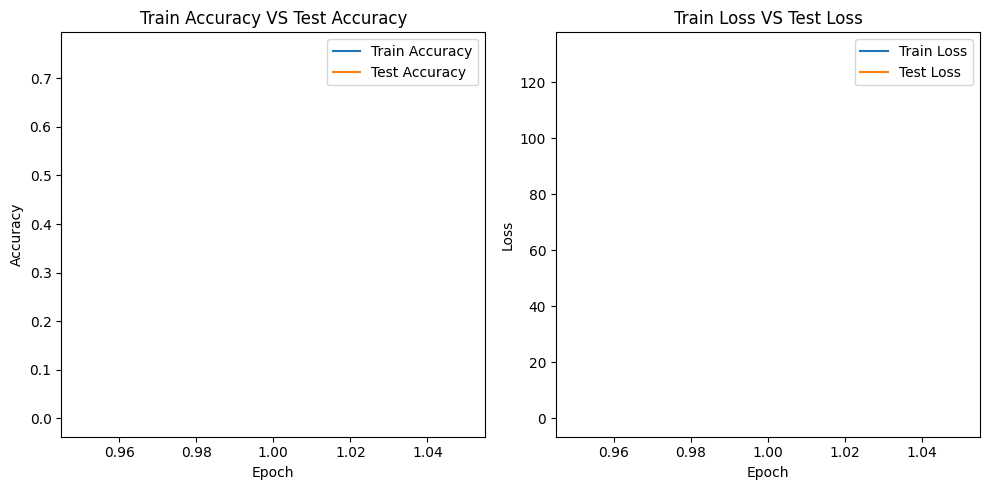

In [ ]:
# Manager.load('bert-base-uncased', path = '/content/drive/MyDrive/Untitled folder/bert-base-uncased trained_model.pt')
Manager.prune('bert-base-uncased')

In [ ]:
# Manager.load('distilbert-base-uncased', path = '/content/drive/MyDrive/Untitled folder/distilbert-base-uncased trained_model.pt')
Manager.prune('distilbert-base-uncased')

Distilation

In [ ]:
# Manager.load('roberta-base', path = '/content/drive/MyDrive/Untitled folder/roberta-base trained_model.pt')
# Manager.load('distilbert-base-uncased', path = '/content/drive/MyDrive/Untitled folder/distilbert-base-uncased trained_model.pt')
Manager.distilation('distilbert-base-uncased', 'roberta-base')

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaForSequenceClassification: ['lm_head.layer_norm.bias', 'lm_head.layer_norm.weight', 'lm_head.dense.bias', 'lm_head.dense.weight', 'lm_head.bias']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.out_proj.weight', 'classifier.dense.bias', 'classifier.out_proj.bias', 'classifier.dense.weight']
You should pr

Distilation Loss epoch 0 : 1.0628154277801514
Classification Loss epoch 0 : 0.6605701446533203
Total Loss epoch 0 : 0.8616927862167358


6300it [15:25,  6.81it/s]


Distilation Loss epoch 1 : 1.107291340827942
Classification Loss epoch 1 : 0.6196465492248535
Total Loss epoch 1 : 0.8634689450263977


6300it [15:25,  6.81it/s]


Distilation Loss epoch 2 : 1.0658910274505615
Classification Loss epoch 2 : 0.4539877474308014
Total Loss epoch 2 : 0.7599393725395203


100%|██████████| 10800/10800 [03:04<00:00, 58.40it/s]


epoch No: 0
train loss: 0
train accuracy 0.0
validation loss: 167.64389322698116
validation accuracy 0.759995601877304



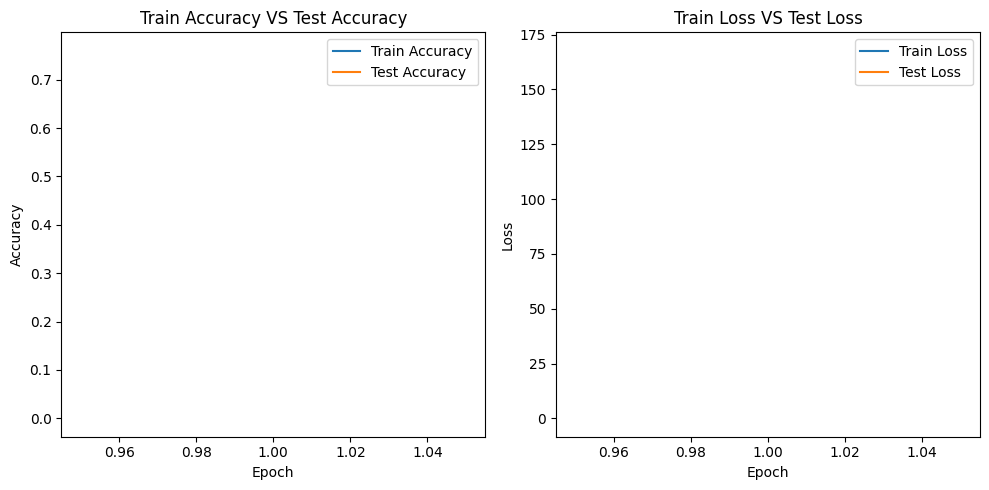

In [ ]:
# Manager.load('roberta-base', path = '/content/drive/MyDrive/Untitled folder/roberta-base trained_model.pt')
# Manager.load('bert-base-uncased', path = '/content/drive/MyDrive/Untitled folder/bert-base-uncased trained_model.pt')
Manager.distilation('bert-base-uncased','roberta-base')

In [ ]:
# Manager.load('bert-base-uncased', path = '/content/drive/MyDrive/Untitled folder/bert-base-uncased trained_model.pt')
# Manager.load('roberta-base', path = '/content/drive/MyDrive/Untitled folder/roberta-base trained_model.pt')
Manager.distilation('roberta-base','bert-base-uncased')

Quantization

In [ ]:
# Manager.load('distilbert-base-uncased', path = '/content/drive/MyDrive/Untitled folder/distilbert-base-uncased trained_model.pt')
Manager.quantize('distilbert-base-uncased')

In [ ]:
# Manager.load('roberta-base', path = '/content/drive/MyDrive/Untitled folder/roberta-base trained_model.pt')
Manager.quantize('roberta-base')

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly i

epoch No: 0
train loss: 0
train accuracy 0.0
validation loss: 144.20724344614428
validation accuracy 0.7406843710395195



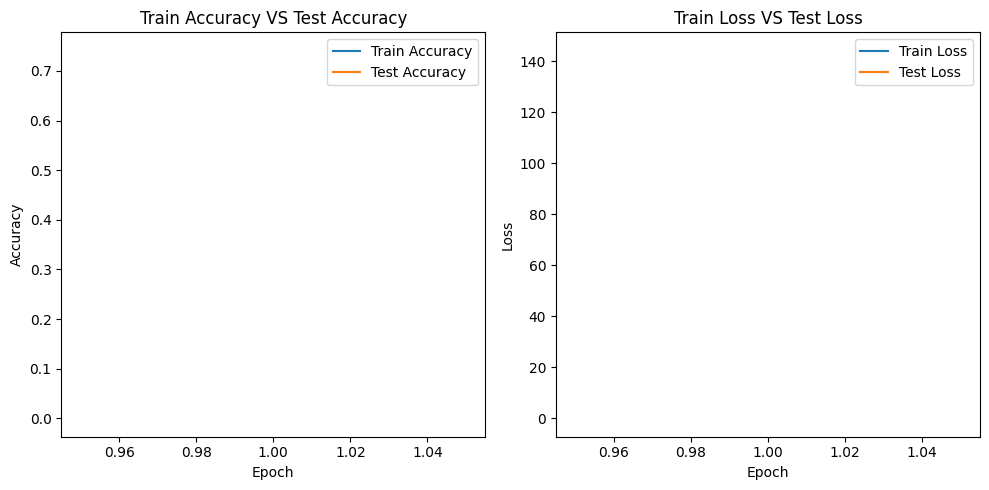

In [ ]:
# Manager.load('bert-base-uncased', path = '/content/drive/MyDrive/Untitled folder/bert-base-uncased trained_model.pt')
Manager.quantize('bert-base-uncased')

In [ ]:
def sum_accuracy():
  l1 = []
  l2 = []
  l3 = []
  output = f'{"model":>10}| {"regular":>10}| {"pruned":>10}| {"quantized":>10}| {"distilled":>10}|\n'
  l1.append(Manager.accuracies['bert-base-uncased'])
  l2.append(Manager.accuracies['roberta-base'])
  l3.append(Manager.accuracies['distilbert-base-uncased'])
  for j in ['pruned', 'quantized','distilled']:
    l1.append(Manager.accuracies[f'bert-base-uncased {j}'])
    l2.append(Manager.accuracies[f'roberta-base {j}'])
    l3.append(Manager.accuracies[f'distilbert-base-uncased {j}'])
  output += f'{"Bert":>10}| {l1[0]:10.2f}| {l1[1]:10.2f}| {l1[2]:10.2f}| {l1[3]:10.2f}|\n'
  output += f'{"Roberta":>10}| {l2[0]:10.2f}| {l2[1]:10.2f}| {l2[2]:10.2f}| {l2[3]:10.2f}|\n'
  output += f'{"distilbert":>10}| {l3[0]:10.2f}| {l3[1]:10.2f}| {l3[2]:10.2f}| {l3[3]:10.2f}|\n'
  print(output)
sum_accuracy()

KeyError: ignored

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sn
import pandas as pd

def conf_matrix(model, manager):
  y_pred = []
  y_true = []
  trainloader, validateloader = manager.create_data_loaders(model)
  # iterate over test data
  for input_ids, attention_mask, targets in tqdm(validateloader):
    input_ids = input_ids.to(manager.device, dtype = torch.long)
    attention_mask = attention_mask.to(manager.device, dtype = torch.long)
    targets = targets.to(manager.device, dtype = torch.float)
    outputs = manager.models[model](input_ids=input_ids, attention_mask=attention_mask, labels=targets)
    output = (torch.max(torch.exp(outputs.logits), 1)[1]).data.cpu().numpy()
    y_pred.extend(output) # Save Prediction
    tars = (torch.max(torch.exp(targets), 1)[1]).data.cpu().numpy()
    y_true.extend(tars) # Save Truth

  # constant for classes
  classes = ('news','culture','opinion','business','sport','lifestyle')

  # Build confusion matrix
  cf_matrix = confusion_matrix(y_true, y_pred)
  df_cm = pd.DataFrame(cf_matrix / np.sum(cf_matrix, axis=1)[:, None], index = [i for i in classes],
                      columns = [i for i in classes])
  plt.figure(figsize = (12,7))
  sn.heatmap(df_cm, annot=True)
  plt.savefig('output.png')

In [ ]:
from sklearn.metrics import classification_report
import seaborn as sn
import pandas as pd

def classification_rep(model, manager):
  y_pred = []
  y_true = []
  trainloader, validateloader = manager.create_data_loaders(model)
  # iterate over test data
  for input_ids, attention_mask, targets in tqdm(validateloader):
    input_ids = input_ids.to(manager.device, dtype = torch.long)
    attention_mask = attention_mask.to(manager.device, dtype = torch.long)
    targets = targets.to(manager.device, dtype = torch.float)
    outputs = manager.models[model](input_ids=input_ids, attention_mask=attention_mask, labels=targets)
    output = (torch.max(torch.exp(outputs.logits), 1)[1]).data.cpu().numpy()
    y_pred.extend(output) # Save Prediction
    tars = (torch.max(torch.exp(targets), 1)[1]).data.cpu().numpy()
    y_true.extend(tars) # Save Truth

  # constant for classes
  classes = ['news','culture','opinion','business','sport','lifestyle']
  print(classification_report(y_true, y_pred, target_names=classes))
  return(classification_report(y_true, y_pred, target_names=classes))

In [ ]:
cl_rep = classification_rep('roberta-base', Manager)

In [ ]:
cl_rep = classification_rep('distilbert-base-uncased', Manager)

In [ ]:
cl_rep = classification_rep('bert-base-uncased', Manager)

100%|██████████| 10800/10800 [06:13<00:00, 28.93it/s]


              precision    recall  f1-score   support

        news       0.80      0.65      0.72     28768
     culture       0.71      0.81      0.76     28592
     opinion       0.80      0.79      0.80     28779
    business       0.78      0.85      0.81     28950
       sport       0.87      0.90      0.88     28963
   lifestyle       0.81      0.77      0.79     28748

    accuracy                           0.79    172800
   macro avg       0.80      0.79      0.79    172800
weighted avg       0.80      0.79      0.79    172800



In [ ]:
conf_matrix('distilbert-base-uncased', Manager)

100%|██████████| 10800/10800 [06:13<00:00, 28.93it/s]


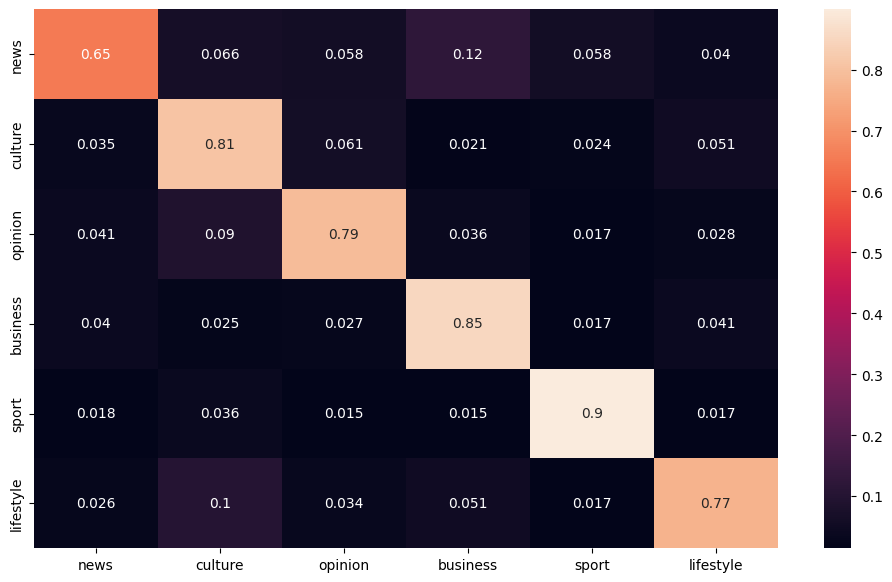

In [ ]:
conf_matrix('bert-base-uncased', Manager)

In [ ]:
conf_matrix('roberta-base', Manager)